In [6]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

from pytorch_fid import fid_score

/tmp/ipykernel_10023/2475230352.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [8]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [9]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [10]:
data, classes = next(iter(train_loader))
classes[0]

tensor(38)

## GAN

In [11]:
NUBMER_OF_CLASSES = 43

In [42]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim + NUBMER_OF_CLASSES, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, classes_encoded):
        x = torch.flatten(x, 1)
        x = torch.concat((x, classes_encoded), dim=1)

        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [43]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim + NUBMER_OF_CLASSES, hidden_dim1)
        self.fc_2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=16, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=16, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=8, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=4, stride=1, padding=2)


        self.fc_4 = nn.Linear(hidden_dim2, output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, classes_encoded):
        h = torch.concat((x, classes_encoded), dim=1)

        h     = self.LeakyReLU(self.fc_1(h))
        h = self.bn1(h)
        h     = self.LeakyReLU(self.fc_2(h))
        h = self.bn2(h)



        x_hat = torch.sigmoid(self.fc_4(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        x = self.conv1(self.LeakyReLU(x_hat))
        x = self.conv2(self.LeakyReLU(x))
        x = self.conv3(self.LeakyReLU(x))
        x = self.conv4(self.LeakyReLU(x))

        return x_hat

In [44]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim1=64, hidden_dim2=64, output_dim=3072).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [45]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [46]:
def combine(images, encodings):
    encodings = encodings.unsqueeze(0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    encodings = encodings.expand(254, 3, 32, 32, 43)

In [47]:
encoding = one_hot(torch.arange(0, 43), 43)

In [48]:
fixed_noise = torch.randn(8, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.133, discriminator real acc: 0.868


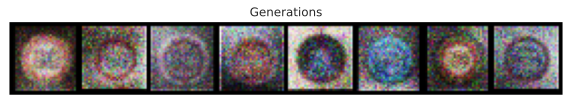

Epoch: 1, discrimiantor fake error: 0.137, discriminator real acc: 0.865
Epoch: 2, discrimiantor fake error: 0.135, discriminator real acc: 0.868
Epoch: 3, discrimiantor fake error: 0.131, discriminator real acc: 0.875
Epoch: 4, discrimiantor fake error: 0.133, discriminator real acc: 0.875
Epoch: 5, discrimiantor fake error: 0.139, discriminator real acc: 0.869
Epoch: 6, discrimiantor fake error: 0.135, discriminator real acc: 0.875
Epoch: 7, discrimiantor fake error: 0.126, discriminator real acc: 0.881
Epoch: 8, discrimiantor fake error: 0.126, discriminator real acc: 0.882
Epoch: 9, discrimiantor fake error: 0.129, discriminator real acc: 0.878
Epoch: 10, discrimiantor fake error: 0.125, discriminator real acc: 0.877


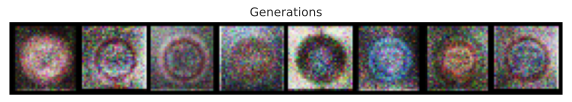

Epoch: 11, discrimiantor fake error: 0.124, discriminator real acc: 0.875
Epoch: 12, discrimiantor fake error: 0.123, discriminator real acc: 0.876
Epoch: 13, discrimiantor fake error: 0.129, discriminator real acc: 0.875
Epoch: 14, discrimiantor fake error: 0.127, discriminator real acc: 0.879
Epoch: 15, discrimiantor fake error: 0.126, discriminator real acc: 0.886
Epoch: 16, discrimiantor fake error: 0.127, discriminator real acc: 0.883
Epoch: 17, discrimiantor fake error: 0.128, discriminator real acc: 0.879
Epoch: 18, discrimiantor fake error: 0.125, discriminator real acc: 0.878
Epoch: 19, discrimiantor fake error: 0.123, discriminator real acc: 0.88
Epoch: 20, discrimiantor fake error: 0.12, discriminator real acc: 0.88


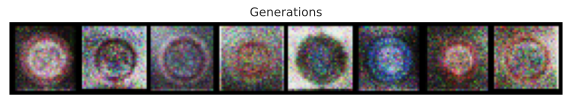

Epoch: 21, discrimiantor fake error: 0.121, discriminator real acc: 0.879
Epoch: 22, discrimiantor fake error: 0.122, discriminator real acc: 0.88
Epoch: 23, discrimiantor fake error: 0.121, discriminator real acc: 0.881
Epoch: 24, discrimiantor fake error: 0.121, discriminator real acc: 0.882
Epoch: 25, discrimiantor fake error: 0.12, discriminator real acc: 0.886


In [ ]:
G_losses = []
D_losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        classes_encoded = get_classes_encoded(train_classes, data[1], encoding).to(device)
        real_images = data[0].to(device)

        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images, classes_encoded).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator

        fake_images = generator(noise, classes_encoded)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach(), classes_encoded).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D

        output = discriminator(fake_images, classes_encoded).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
   
    if epoch % 10 == 0:
        classes_encoded_small = get_classes_encoded(train_classes, [torch.tensor(1), torch.tensor(2),torch.tensor(3),torch.tensor(16),torch.tensor(23),\
                                                                torch.tensor(34),torch.tensor(8),torch.tensor(9)], encoding).to(device)
        with torch.no_grad():
            fake = generator(fixed_noise, classes_encoded_small).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [ ]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [ ]:
input_imgs = get_train_images(8)

In [ ]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    rmd_to_genrate = torch.randn([n_imgs, model.latent_dim])
    classes_to_generate = torch.concat((rmd_to_genrate, encoding[:n_imgs]), dim=1)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

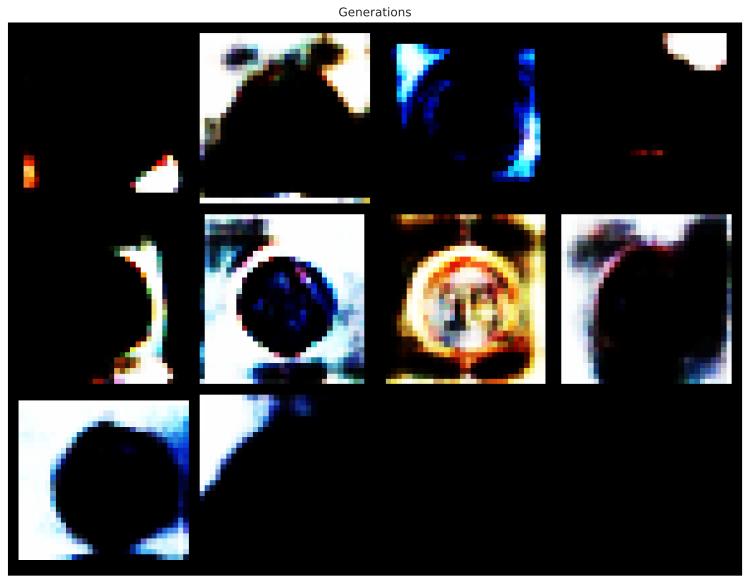

In [ ]:
generate_images(vae, 10, device)

In [ ]:
def im_save(img, path):
    img = img / 2 + 0.5     # unnormalize
    save_image(img, path)

def evaluate_model(model, train_data, encoding: list, train_classes):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    rmd_to_genrate = torch.randn([10, model.latent_dim])
    encoded_classes = get_classes_encoded(train_classes, labels, encoding)

    classes_to_generate = torch.concat((rmd_to_genrate, encoded_classes), dim=1)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()
    for i, img in enumerate(generated_imgs):
        im_save(img, f'gen_eval/img{i}.jpg')
    for i, img in enumerate(images):
        im_save(img, f'real_eval/img{i}.jpg')
    paths = ['real_eval', 'gen_eval']
    return fid_score.calculate_fid_given_paths(paths, batch_size=200, device='cpu', dims=2048)


In [ ]:
evaluate_model(vae, train_data, encoding, train_classes)

RuntimeError: Invalid path: /home/michal/sem6/ssne/ssne/real_eval, /home/michal/sem6/ssne/ssne/gen_eval